In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
# !tar xf spark-3.4.0-bin-hadoop3.tgz
# !pip install -q findspark

## Importando bibliotecas

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, sum, round
spark = SparkSession.builder.appName("AirbnbProcessing").getOrCreate()

## Carregando dados do Airbnb

In [3]:
listings_path = '/content/drive/MyDrive/UFAL/MESTRADO/gerencia e processamento de dados/airbnb-data/airbnb-listings.csv'

listings_df = spark.read \
  .option('multiLine', 'True') \
  .option('escape', '"') \
  .option("mode", "DROPMALFORMED") \
  .option("delimiter", ";") \
  .csv(listings_path, header=True)


## Preprocessando dados

In [4]:
def rename_columns(df):
    for old_name in df.columns:
        new_name = old_name.lower().replace(" ", "_")
        df = df.withColumnRenamed(old_name, new_name)
    return df

listings_df = rename_columns(listings_df)

In [5]:
listings_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [6]:
listings_df = listings_df.select("id","host_id", "price","review_scores_rating", "review_scores_rating",\
                                 "city","neighbourhood_cleansed","property_type", "room_type", "first_review",\
                                 "last_review", "cancellation_policy", "host_since").cache()

In [7]:
# print(listings_df.count())

In [8]:
listings_df.show(5)

+--------+--------+-----+--------------------+--------------------+---------+----------------------+-------------+---------------+------------+-----------+-------------------+----------+
|      id| host_id|price|review_scores_rating|review_scores_rating|     city|neighbourhood_cleansed|property_type|      room_type|first_review|last_review|cancellation_policy|host_since|
+--------+--------+-----+--------------------+--------------------+---------+----------------------+-------------+---------------+------------+-----------+-------------------+----------+
| 4008728|20786453|  600|                  89|                  89|Amsterdam|  De Baarsjes - Oud...|    Apartment|Entire home/apt|  2015-08-02| 2016-11-27|             strict|2014-09-01|
| 7778612|11964927|  175|                  99|                  99|Amsterdam|  De Baarsjes - Oud...|    Apartment|Entire home/apt|  2015-09-28| 2017-01-19|             strict|2014-02-05|
| 8264596|23669273|  125|                 100|                 10

In [9]:
listings_df2 = listings_df.withColumn('price1', regexp_replace('price', '\\$', ''))
listings_df2 = listings_df2.withColumn('price1', regexp_replace('price1', ',', ''))
listings_df2 = listings_df2.withColumn('price1', col('price1').cast('float'))
listings_df2 = listings_df2.withColumn('review_scores_rating1', col('review_scores_rating').cast('float'))
listings_df2 = listings_df2.withColumn('listing_value', round(col('price1')/col('review_scores_rating1'),2))
listings_df2.createOrReplaceTempView("listings_df2")

listings_df2.printSchema()

root
 |-- id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- review_scores_rating: string (nullable = true)
 |-- review_scores_rating: string (nullable = true)
 |-- city: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- first_review: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- price1: float (nullable = true)
 |-- review_scores_rating1: float (nullable = true)
 |-- listing_value: double (nullable = true)



## Análise de dados

In [10]:
cancellation_counts = spark.sql("""SELECT cancellation_policy, COUNT(*) as count 
FROM listings_df2 
GROUP BY cancellation_policy 
ORDER BY count DESC""")

cancellation_counts.show()

+-------------------+------+
|cancellation_policy| count|
+-------------------+------+
|             strict|182834|
|           flexible|156371|
|           moderate|122245|
|       moderate_new| 11717|
|         strict_new| 10113|
|       flexible_new|  9404|
|    super_strict_60|  1321|
|    super_strict_30|   874|
|super_strict_30_new|    41|
|super_strict_60_new|    24|
|         no_refunds|     6|
|               null|     2|
|          long_term|     2|
+-------------------+------+



In [ ]:
room_type_counts = spark.sql("""
SELECT room_type, COUNT(*) as count
FROM listings_df2
WHERE room_type <> '9'
GROUP BY room_type
""")

room_type_counts = room_type_counts.na.drop(subset=["room_type"])

room_type_counts_pd = room_type_counts.toPandas()

plt.bar(room_type_counts_pd['room_type'], room_type_counts_pd['count'])
plt.xlabel('room type')
plt.ylabel('total listing')
plt.title('Total listing per room type')
plt.show()

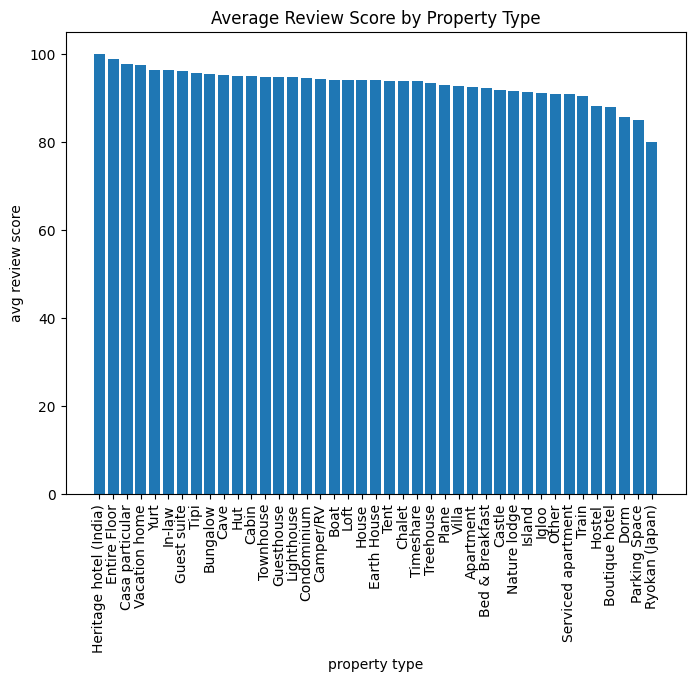

In [ ]:
average_review_score_by_property_type = spark.sql("""
SELECT property_type, AVG(CAST(review_scores_rating AS FLOAT)) as average_review_score
FROM listings_df2
WHERE CAST(review_scores_rating AS FLOAT) > 0
GROUP BY property_type
""")

average_review_score_by_property_type = average_review_score_by_property_type.na.drop(subset=["property_type"])

average_review_score_by_property_type_pd = average_review_score_by_property_type.toPandas()

average_review_score_by_property_type_pd = average_review_score_by_property_type_pd.sort_values('average_review_score', ascending=False)

plt.figure(figsize=(8,6))
plt.bar(average_review_score_by_property_type_pd['property_type'], average_review_score_by_property_type_pd['average_review_score'])
plt.xlabel('property type')
plt.ylabel('avg review score')
plt.title('Average Review Score by Property Type')
plt.xticks(rotation=90)
plt.show()

In [ ]:
growth_analysis = spark.sql("""SELECT SUBSTRING(host_since, 1, 7) AS registration_month, COUNT(*) as listings_count 
FROM listings_df2 
GROUP BY registration_month 
ORDER BY listings_count DESC""")
growth_analysis.show()

+------------------+--------------+
|registration_month|listings_count|
+------------------+--------------+
|           2015-07|         12807|
|           2015-06|         12153|
|           2015-05|         12001|
|           2014-07|         10728|
|           2015-08|         10665|
|           2015-04|          9666|
|           2015-03|          9666|
|           2015-09|          9523|
|           2014-06|          9481|
|           2014-05|          9413|
|           2016-06|          9384|
|           2015-11|          9319|
|           2015-12|          9124|
|           2016-05|          9082|
|           2014-08|          9076|
|           2014-04|          9048|
|           2015-10|          9047|
|           2016-03|          8963|
|           2016-01|          8962|
|           2016-04|          8479|
+------------------+--------------+
only showing top 20 rows



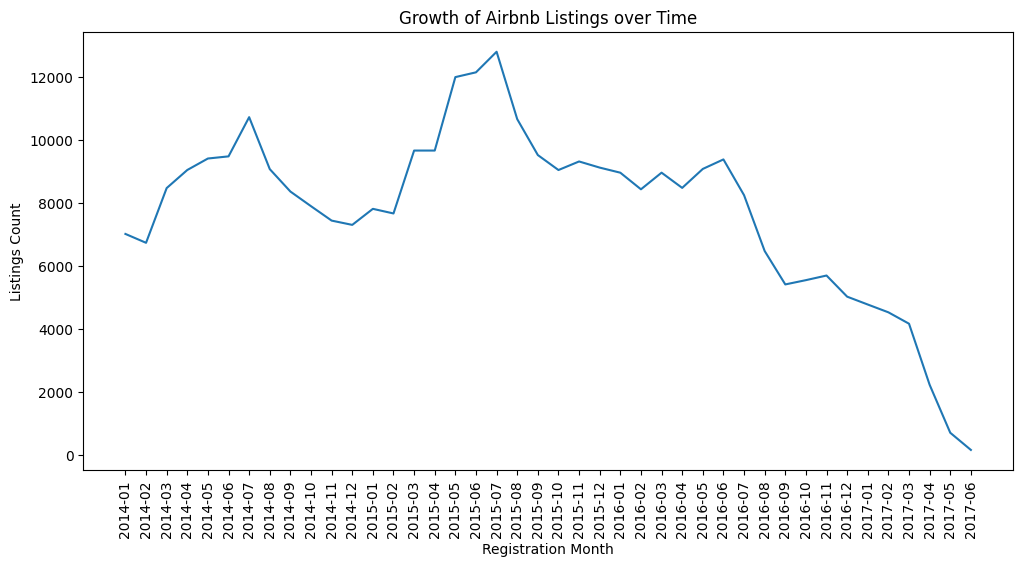

In [ ]:
growth_analysis = spark.sql("""SELECT SUBSTRING(host_since, 1, 7) AS registration_month, COUNT(*) as listings_count 
FROM listings_df2 
WHERE host_since IS NOT NULL AND host_since >= '2014-01'
GROUP BY registration_month 
ORDER BY listings_count DESC""")

growth_analysis = growth_analysis.toPandas().sort_values('registration_month')

plt.figure(figsize=(12, 6))
plt.plot(growth_analysis['registration_month'], growth_analysis['listings_count'])
plt.xlabel('Registration Month')
plt.ylabel('Listings Count')
plt.title('Growth of Airbnb Listings over Time')

plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.15)

plt.show()

In [ ]:
listing_total = spark.sql("""SELECT city, count(id) as total_listing, count(DISTINCT neighbourhood_cleansed) as total_neighbourhood
FROM listings_df2
GROUP BY city
ORDER BY total_listing DESC""")

listing_total.show(30)

+-------------+-------------+-------------------+
|         city|total_listing|total_neighbourhood|
+-------------+-------------+-------------------+
|        Paris|        54513|                 20|
|       London|        47423|                 33|
|       Berlin|        20454|                137|
|     New York|        19528|                 98|
|  Los Angeles|        19426|                147|
|         Roma|        18618|                 15|
|    Barcelona|        17431|                 73|
|     Brooklyn|        16419|                 55|
|    Amsterdam|        14869|                 22|
|    København|        13805|                 11|
|       Madrid|        13207|                125|
|      Toronto|        12624|                139|
|       Austin|         9563|                 45|
|San Francisco|         8680|                 37|
|   Washington|         7692|                 39|
|     Montréal|         7659|                 25|
|    San Diego|         6201|                 85|


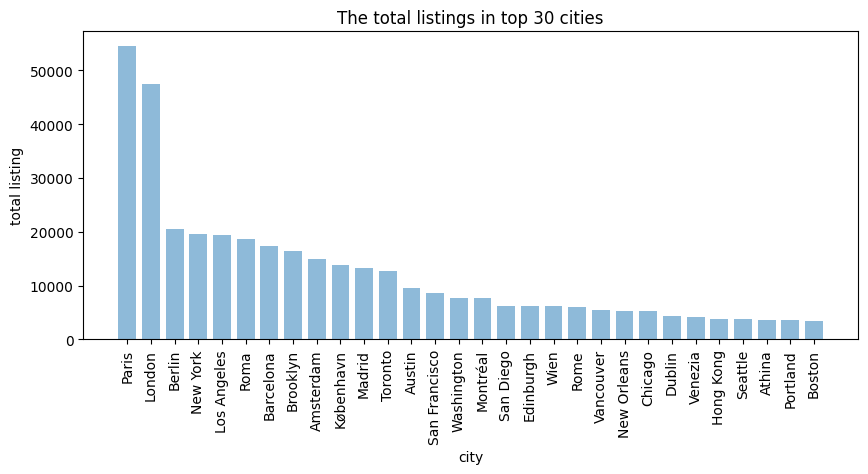

In [ ]:
list_small = listing_total.limit(30).toPandas()
num = len(list_small)*4
c = [i for i in range(0,num,4)]
plt.figure(figsize=(10,4))
plt.bar(c, list_small['total_listing'],width=3, align='center', alpha=0.5)
plt.xticks(c,list_small['city'],rotation=90)

plt.ylabel('total listing')
plt.xlabel('city')
plt.title('The total listings in top 30 cities')
plt.show()

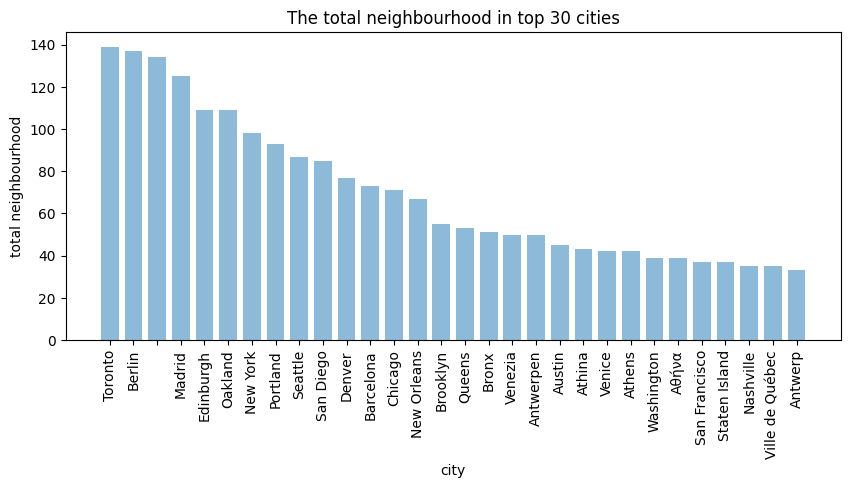

In [ ]:
neighbourhood_list = listing_total.sort("total_neighbourhood", ascending=False)
neighbourhood_list_pd = neighbourhood_list.toPandas() 
list_neighbourhood_30 = neighbourhood_list_pd.iloc[1:31];
num = len(list_neighbourhood_30)*4
c = [i for i in range(0,num,4)]
plt.figure(figsize=(10,4))
plt.bar(c, list_neighbourhood_30['total_neighbourhood'],width=3, align='center', alpha=0.5)

plt.xticks(c,list_neighbourhood_30['city'],rotation=90)
plt.ylabel('total neighbourhood')
plt.xlabel('city')
plt.title('The total neighbourhood in top 30 cities')
plt.show()

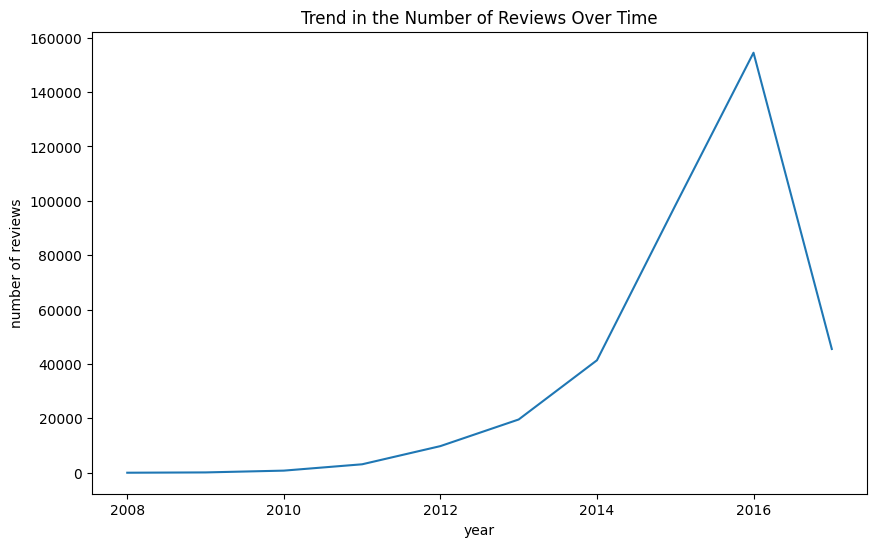

In [ ]:
reviews_trend = spark.sql("""
SELECT YEAR(first_review) as year, COUNT(*) as count
FROM listings_df2
WHERE first_review IS NOT NULL
GROUP BY year
ORDER BY year
""")

reviews_trend_pd = reviews_trend.toPandas()

plt.figure(figsize=(10,6))
plt.plot(reviews_trend_pd['year'], reviews_trend_pd['count'])
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.title('Trend in the Number of Reviews Over Time')
plt.show()


## Cidade de Paris

In [ ]:
neighbourhood_property = spark.sql("""SELECT neighbourhood_cleansed, count(DISTINCT property_type) as property_type_count
FROM listings_df2
WHERE city = 'Paris'
GROUP BY neighbourhood_cleansed
ORDER BY property_type_count DESC""")

neighbourhood_property.show()

+----------------------+-------------------+
|neighbourhood_cleansed|property_type_count|
+----------------------+-------------------+
|             Vaugirard|                 17|
|                 Passy|                 16|
|              Gobelins|                 14|
|              Entrepôt|                 13|
|          Observatoire|                 13|
|     Buttes-Montmartre|                 13|
|                Élysée|                 13|
|            Luxembourg|                 13|
|          Ménilmontant|                 12|
|              Panthéon|                 12|
|            Popincourt|                 11|
|       Buttes-Chaumont|                 11|
|        Hôtel-de-Ville|                 11|
|   Batignolles-Monceau|                 11|
|                Bourse|                 11|
|                 Opéra|                 10|
|        Palais-Bourbon|                 10|
|                Louvre|                 10|
|               Reuilly|                  9|
|         

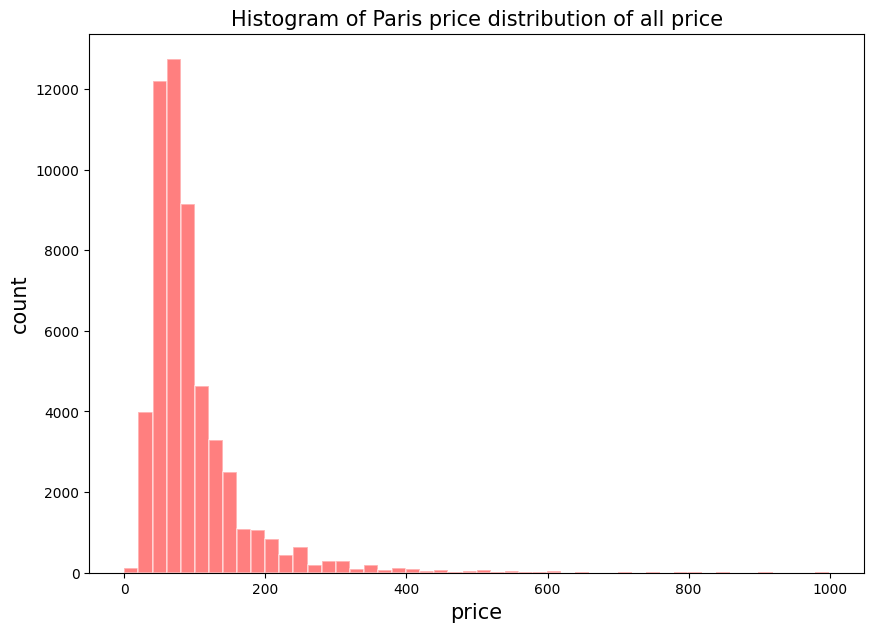

In [ ]:
paris_price = spark.sql("""SELECT price1 as price 
FROM listings_df2
WHERE city = 'Paris'""")

paris_price_pd = paris_price.toPandas()

plt.figure(figsize = (10,7))
plt.hist(paris_price_pd['price'],bins = 50,alpha = 0.5,color = 'red',edgecolor = 'white', linewidth = 1.2)
plt.xlabel('price',size  =  15)
plt.ylabel('count',size  =  15)
plt.title('Histogram of Paris price distribution of all price',size  =  15)
plt.show()

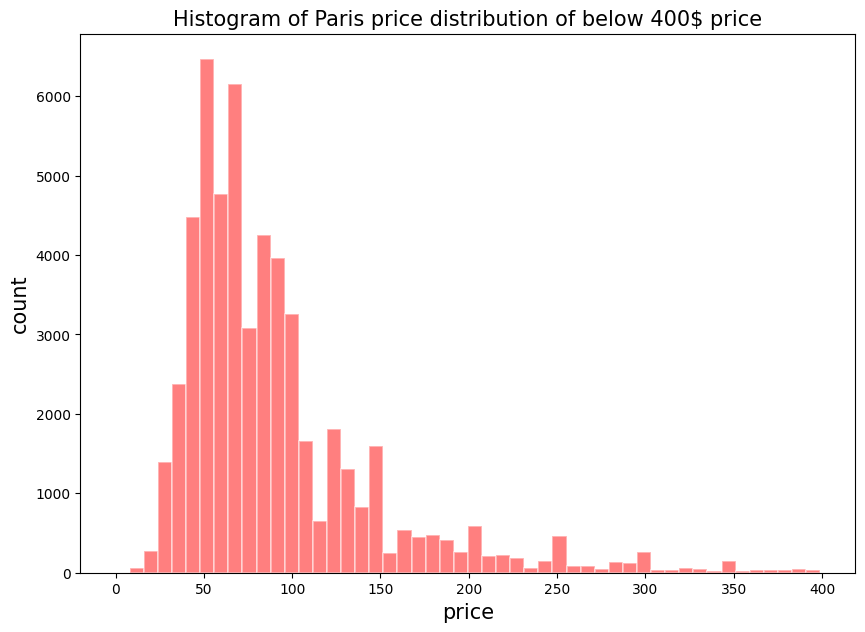

In [ ]:
lowPrice = 400
paris_price_low_pd = paris_price.filter(paris_price["price"]<lowPrice).toPandas()

plt.figure(figsize = (10,7))
plt.hist(paris_price_low_pd['price'],bins = 50,alpha = 0.5,color = 'red',edgecolor = 'white', linewidth = 1.2)
plt.xlabel('price',size  =  15)
plt.ylabel('count',size  =  15)
plt.title('Histogram of Paris price distribution of below 400$ price',size  =  15)
plt.show()

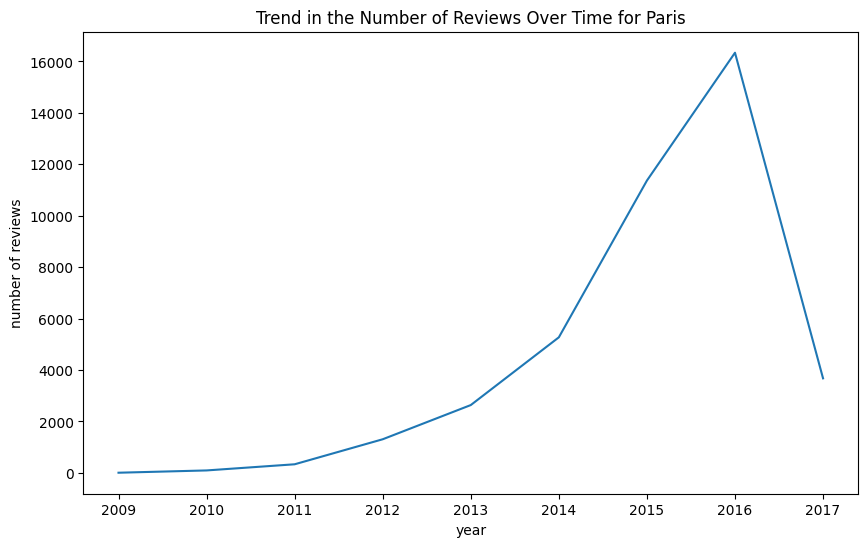

In [ ]:
reviews_trend_paris = spark.sql("""
SELECT YEAR(first_review) as year, COUNT(*) as count
FROM listings_df2
WHERE first_review IS NOT NULL AND city = 'Paris'
GROUP BY year
ORDER BY year
""")

reviews_trend_paris_pd = reviews_trend_paris.toPandas()

plt.figure(figsize=(10,6))
plt.plot(reviews_trend_paris_pd['year'], reviews_trend_paris_pd['count'])
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.title('Trend in the Number of Reviews Over Time for Paris')
plt.show()


## Cidade de Londres

In [ ]:
neighbourhood_property_london = spark.sql("""SELECT neighbourhood_cleansed, count(DISTINCT property_type) as property_type_count
FROM listings_df2
WHERE city = 'London'
GROUP BY neighbourhood_cleansed
ORDER BY property_type_count DESC""")

neighbourhood_property_london.show()

+----------------------+-------------------+
|neighbourhood_cleansed|property_type_count|
+----------------------+-------------------+
|             Southwark|                 17|
|            Wandsworth|                 16|
|         Tower Hamlets|                 16|
|               Lambeth|                 14|
|                Camden|                 14|
|  Kensington and Ch...|                 14|
|             Islington|                 14|
|           Westminster|                 14|
|               Hackney|                 14|
|                Newham|                 12|
|              Haringey|                 12|
|                Merton|                 12|
|  Hammersmith and F...|                 12|
|                 Brent|                 11|
|             Greenwich|                 10|
|                Barnet|                 10|
|                Ealing|                 10|
|        Waltham Forest|                 10|
|              Lewisham|                 10|
|         

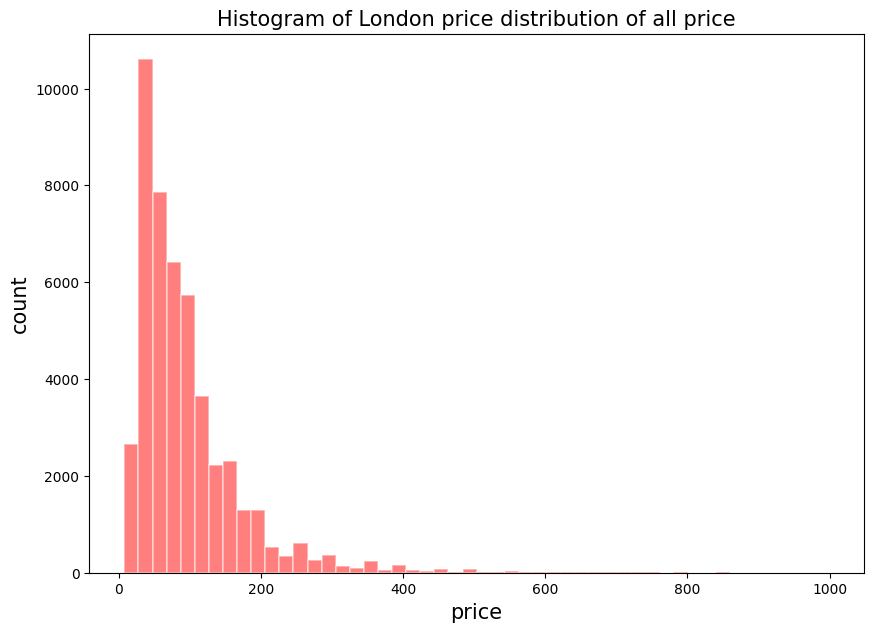

In [ ]:
london_price = spark.sql("""SELECT price1 as price 
FROM listings_df2
WHERE city = 'London'""")

london_price_pd = london_price.toPandas()

plt.figure(figsize = (10,7))
plt.hist(london_price_pd['price'],bins = 50,alpha = 0.5,color = 'red',edgecolor = 'white', linewidth = 1.2)
plt.xlabel('price',size  =  15)
plt.ylabel('count',size  =  15)
plt.title('Histogram of London price distribution of all price',size  =  15)
plt.show()

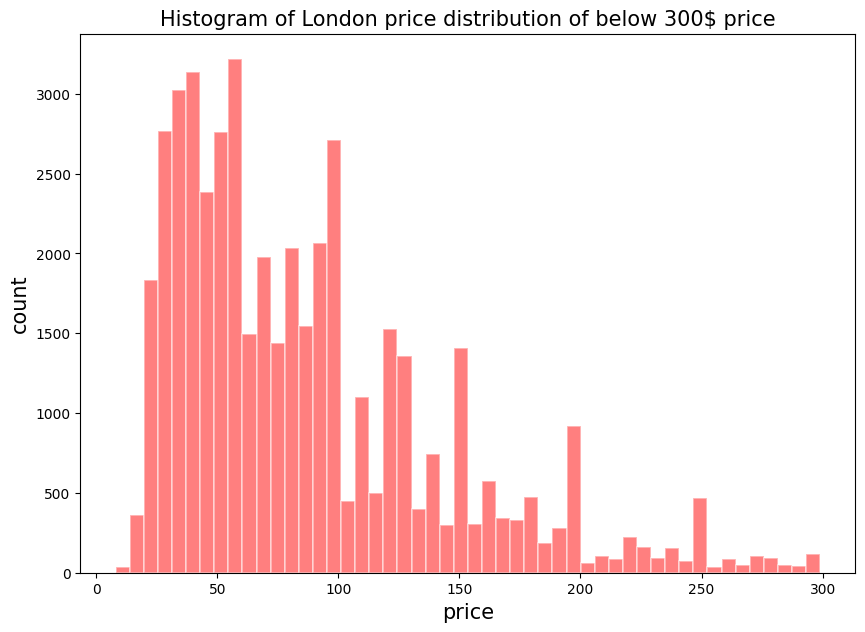

In [ ]:
lowPrice = 300
london_price_low_pd = london_price.filter(london_price["price"]<lowPrice).toPandas()

plt.figure(figsize = (10,7))
plt.hist(london_price_low_pd['price'],bins = 50,alpha = 0.5,color = 'red',edgecolor = 'white', linewidth = 1.2)
plt.xlabel('price', size = 15)
plt.ylabel('count', size = 15)
plt.title('Histogram of London price distribution of below 300$ price', size = 15)
plt.show()

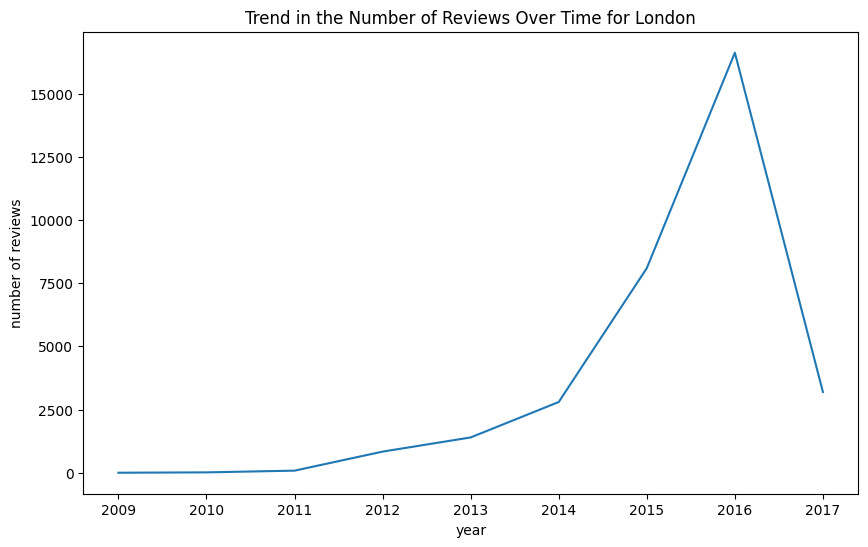

In [ ]:
reviews_trend_london = spark.sql("""
SELECT YEAR(first_review) as year, COUNT(*) as count
FROM listings_df2
WHERE first_review IS NOT NULL AND city = 'London'
GROUP BY year
ORDER BY year
""")

reviews_trend_london_pd = reviews_trend_london.toPandas()

plt.figure(figsize=(10,6))
plt.plot(reviews_trend_london_pd['year'], reviews_trend_london_pd['count'])
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.title('Trend in the Number of Reviews Over Time for London')
plt.show()


## Cidade de Berlim

In [ ]:
neighbourhood_property = spark.sql("""SELECT neighbourhood_cleansed, count(DISTINCT property_type) as property_type_count
FROM listings_df2
WHERE city = 'Berlin'
GROUP BY neighbourhood_cleansed
ORDER BY property_type_count DESC""")

neighbourhood_property.show()

+----------------------+-------------------+
|neighbourhood_cleansed|property_type_count|
+----------------------+-------------------+
|        Alexanderplatz|                 13|
|          Reuterstraße|                 12|
|  Tempelhofer Vorstadt|                 10|
|      Brunnenstr. Nord|                 10|
|       Brunnenstr. Süd|                 10|
|  Frankfurter Allee...|                 10|
|               Westend|                  9|
|       Wedding Zentrum|                  9|
|           Heerstrasse|                  9|
|             Tempelhof|                  9|
|      Zehlendorf  Nord|                  9|
|   Karl-Marx-Allee-Süd|                  8|
|  Prenzlauer Berg N...|                  8|
|            Moabit Ost|                  8|
|           Moabit West|                  8|
|     Regierungsviertel|                  8|
|              Halensee|                  8|
|     Schillerpromenade|                  7|
|        Schöneberg-Süd|                  7|
|  Prenzla

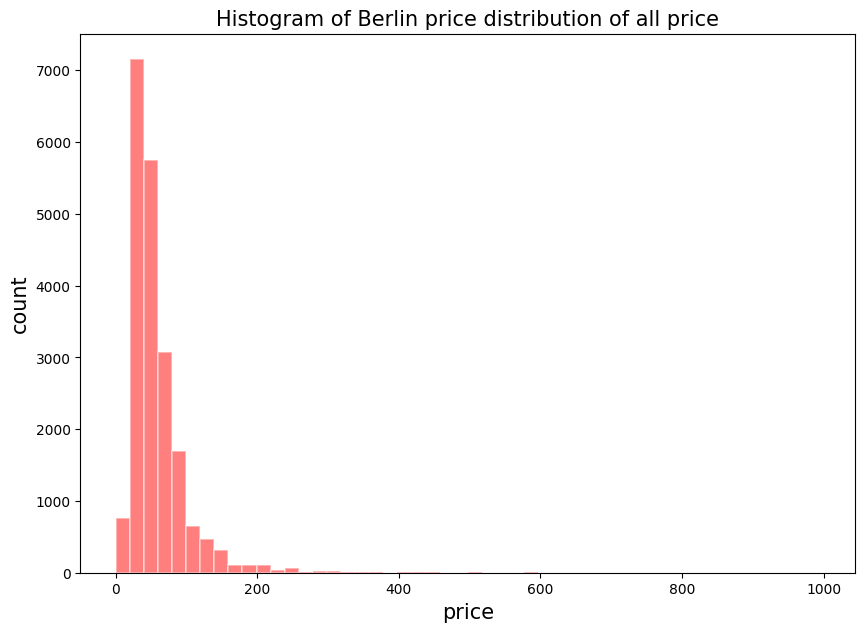

In [ ]:
berlin_price = spark.sql("""SELECT price1 as price 
FROM listings_df2
WHERE city = 'Berlin'""")

berlin_price_pd = berlin_price.toPandas()

plt.figure(figsize = (10,7))
plt.hist(berlin_price_pd['price'],bins = 50,alpha = 0.5,color = 'red',edgecolor = 'white', linewidth = 1.2)
plt.xlabel('price',size  =  15)
plt.ylabel('count',size  =  15)
plt.title('Histogram of Berlin price distribution of all price',size  =  15)
plt.show()

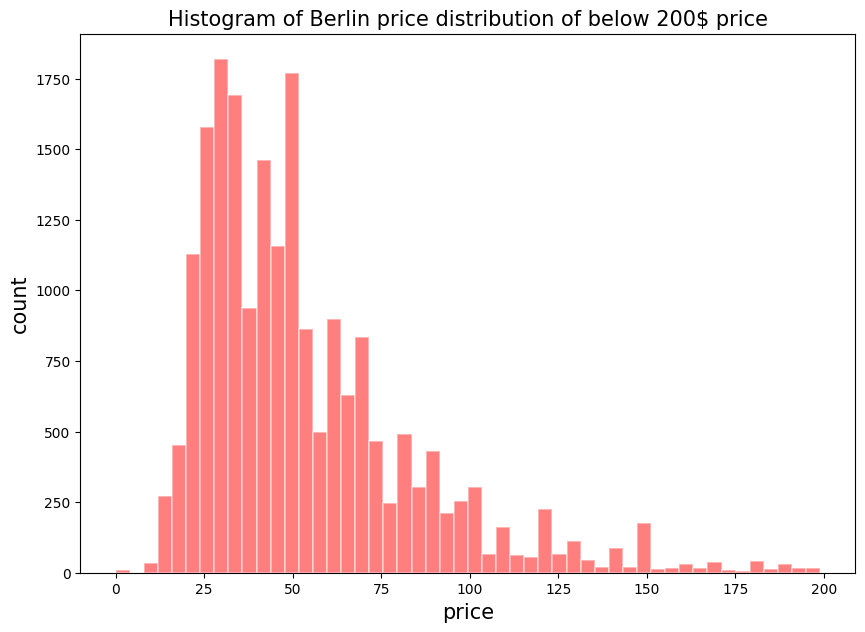

In [ ]:
lowPrice = 200
berlin_price_low_pd = berlin_price.filter(berlin_price["price"]<lowPrice).toPandas()

plt.figure(figsize = (10,7))
plt.hist(berlin_price_low_pd['price'],bins = 50,alpha = 0.5,color = 'red',edgecolor = 'white', linewidth = 1.2)
plt.xlabel('price', size = 15)
plt.ylabel('count', size = 15)
plt.title('Histogram of Berlin price distribution of below 200$ price', size = 15)
plt.show()

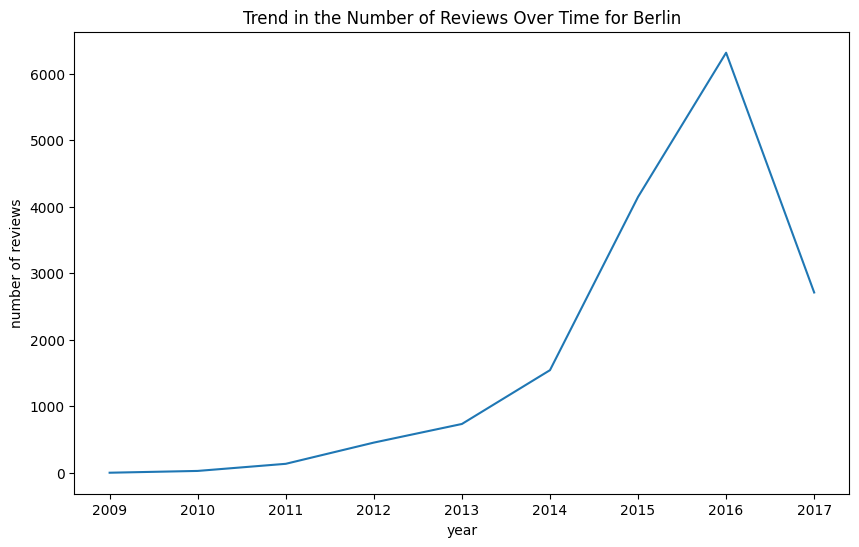

In [ ]:
reviews_trend_berlin = spark.sql("""
SELECT YEAR(first_review) as year, COUNT(*) as count
FROM listings_df2
WHERE first_review IS NOT NULL AND city = 'Berlin'
GROUP BY year
ORDER BY year
""")

reviews_trend_berlin_pd = reviews_trend_berlin.toPandas()

plt.figure(figsize=(10,6))
plt.plot(reviews_trend_berlin_pd['year'], reviews_trend_berlin_pd['count'])
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.title('Trend in the Number of Reviews Over Time for Berlin')
plt.show()
